# Text Classification using HuggingFace transformers

参考：
- https://huggingface.co/docs/transformers/ja/training
- https://huggingface.co/docs/transformers/tasks/sequence_classification

利用モデル
- https://huggingface.co/line-corporation/line-distilbert-base-japanese
- https://huggingface.co/line-corporation/line-distilbert-base-japanese/blob/main/config.json

In [133]:
import datasets
print(datasets.__version__)
import transformers
print(transformers.__version__)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

2.19.0
4.40.1


In [4]:
df = pd.read_csv('./tmp/amazon_review_sample1k.csv')
print(df.shape)
df.sample(10)

(1000, 3)


,text,rating,label
579,英語が堪能な知り合いのブログで紹介されていて、この度自分も英語を勉強しに海外へ行くので文法の...,5,0
633,どっちが先に出たかしりませんが、確かにアントールドな歴史です。興味深い。,4,0
49,句動詞の勉強の為に購入しました。以前English Phrasal Verbs in Use...,5,0
14,値段も少し高めだが、中身は充実していると思う。まずは普通の公式本をしっかり解いてからなのです...,3,1
372,アマチュア無線を趣味としている者として、世界の最新のトレンドが理解でき大変参考となった。,5,0
227,どの章も読みにくく、女性にむけてなのか 男性に向けてなのかわからず結局 男女は違うんだ てこ...,1,1
189,私は6年前くらいに3000円でTSU◯AYAで買いましたよもちろん新品で杖よりお気に入りです,5,0
34,沢山の方が高いレビューされているとおり英語を教える人にとっては、日本語の文法教材より理解しやすい.,5,0
311,日本語の字幕がないので全く意味がわからない。日本語字幕付きがあれば、すぐにでも注文したいので...,1,1
250,28日間の感謝のやり方が書かれた本です。the secretの実践本です。まだ途中ですが、か...,5,0


In [5]:
df['label'].value_counts()

label
0    850
1    150
Name: count, dtype: int64

-  label=1 : ratingが3以下（Negative）
-  label=0 : ratingが4以上（Positive）

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=123)
df_train.shape, df_test.shape

((800, 3), (200, 3))

### datasets.Datasetの準備

In [7]:
# 直接csvを読み込む場合
datasets.load_dataset('csv', data_files=['./tmp/amazon_review_sample1k.csv'])

DatasetDict({
    train: Dataset({
        features: ['text', 'rating', 'label'],
        num_rows: 1000
    })
})

In [8]:
# pandasから変換
dataset_train = datasets.Dataset.from_pandas(df_train[['text','label']], preserve_index=False)
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 800
})

In [9]:
type(dataset_train)

datasets.arrow_dataset.Dataset

In [10]:
dataset_train['text'][0]

'全編英語だけど絵が多いので英語苦手な人でも作れると思いますが、もちろん\x08細かく細かく全てのステップの図解が載っている訳ではないので自己責任でご購入を検討してくださいませ。すごく沢山の種類が載っておりかなり楽しめました。一生のバイブルになるでしょう。'

In [11]:
dataset_train['label'][0]

0

In [12]:
dataset_test = datasets.Dataset.from_pandas(df_test[['text','label']], preserve_index=False)
dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 200
})

### Tokenizerの適用

Tokenizerに関して: https://huggingface.co/docs/transformers/ja/tokenizer_summary

In [13]:
#!pip install fugashi sentencepiece　unidic-lite

In [574]:
tokenizer = AutoTokenizer.from_pretrained('line-corporation/line-distilbert-base-japanese')
tokenizer

BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [575]:
type(tokenizer)

transformers.models.bert_japanese.tokenization_bert_japanese.BertJapaneseTokenizer

https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/bert_japanese/tokenization_bert_japanese.html

In [576]:
dataset_train['text'][0], dataset_train['label'][0]

('全編英語だけど絵が多いので英語苦手な人でも作れると思いますが、もちろん\x08細かく細かく全てのステップの図解が載っている訳ではないので自己責任でご購入を検討してくださいませ。すごく沢山の種類が載っておりかなり楽しめました。一生のバイブルになるでしょう。',
 0)

In [577]:
tokenizer(dataset_train['text'][0])

{'input_ids': [2, 180, 10807, 1685, 47, 524, 1749, 14, 621, 5, 9, 1685, 5231, 16, 54, 9, 20, 124, 368, 15, 318, 39, 14, 6, 1784, 10234, 13016, 10143, 10143, 1363, 5, 4487, 5, 788, 10611, 14, 10039, 12, 42, 3031, 9, 10, 50, 5, 9, 2593, 2767, 9, 162, 949, 13, 2678, 17, 12, 525, 231, 8, 3947, 5442, 5, 1551, 14, 10039, 12, 282, 1546, 7365, 70, 11, 8, 6202, 5, 2191, 774, 7, 136, 502, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [578]:
len(tokenizer(dataset_train['text'][0])['input_ids'])

79

In [579]:
tokenizer.decode(
    tokenizer(dataset_train['text'][0])['input_ids']
)

'全編 英語 だ けど 絵 が 多い の で 英語 苦手 な 人 で も 作れる と 思い ます が 、 もちろん \x08 細かく 細かく 全て の ステップ の 図解 が 載っ て いる 訳 で は ない の で 自己 責任 で ご 購入 を 検討 し て ください ませ 。 すごく 沢山 の 種類 が 載っ て おり かなり 楽しめ まし た 。 一生 の バイブル に なる でしょう 。'

In [580]:
# トークン化
tokenizer.tokenize(dataset_train['text'][0])

['▁全',
 '編',
 '▁英語',
 '▁だ',
 '▁けど',
 '▁絵',
 '▁が',
 '▁多い',
 '▁の',
 '▁で',
 '▁英語',
 '▁苦手',
 '▁な',
 '▁人',
 '▁で',
 '▁も',
 '▁作',
 'れる',
 '▁と',
 '▁思い',
 '▁ます',
 '▁が',
 '▁、',
 '▁もちろん',
 '▁',
 '\x08',
 '▁細かく',
 '▁細かく',
 '▁全て',
 '▁の',
 '▁ステップ',
 '▁の',
 '▁図',
 '解',
 '▁が',
 '▁載っ',
 '▁て',
 '▁いる',
 '▁訳',
 '▁で',
 '▁は',
 '▁ない',
 '▁の',
 '▁で',
 '▁自己',
 '▁責任',
 '▁で',
 '▁ご',
 '▁購入',
 '▁を',
 '▁検討',
 '▁し',
 '▁て',
 '▁ください',
 '▁ませ',
 '▁。',
 '▁すごく',
 '▁沢山',
 '▁の',
 '▁種類',
 '▁が',
 '▁載っ',
 '▁て',
 '▁おり',
 '▁かなり',
 '▁楽しめ',
 '▁まし',
 '▁た',
 '▁。',
 '▁一生',
 '▁の',
 '▁バイ',
 'ブル',
 '▁に',
 '▁なる',
 '▁でしょう',
 '▁。']

In [581]:
len(tokenizer.tokenize(dataset_train['text'][0]))

77

In [582]:
# トークンのID変換
tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize(dataset_train['text'][0])
)

[180,
 10807,
 1685,
 47,
 524,
 1749,
 14,
 621,
 5,
 9,
 1685,
 5231,
 16,
 54,
 9,
 20,
 124,
 368,
 15,
 318,
 39,
 14,
 6,
 1784,
 10234,
 13016,
 10143,
 10143,
 1363,
 5,
 4487,
 5,
 788,
 10611,
 14,
 10039,
 12,
 42,
 3031,
 9,
 10,
 50,
 5,
 9,
 2593,
 2767,
 9,
 162,
 949,
 13,
 2678,
 17,
 12,
 525,
 231,
 8,
 3947,
 5442,
 5,
 1551,
 14,
 10039,
 12,
 282,
 1546,
 7365,
 70,
 11,
 8,
 6202,
 5,
 2191,
 774,
 7,
 136,
 502,
 8]

In [583]:
# 特殊トークンの付与
tokenizer.prepare_for_model(
    tokenizer.convert_tokens_to_ids(
        tokenizer.tokenize(dataset_train['text'][0])
    )
)

{'input_ids': [2, 180, 10807, 1685, 47, 524, 1749, 14, 621, 5, 9, 1685, 5231, 16, 54, 9, 20, 124, 368, 15, 318, 39, 14, 6, 1784, 10234, 13016, 10143, 10143, 1363, 5, 4487, 5, 788, 10611, 14, 10039, 12, 42, 3031, 9, 10, 50, 5, 9, 2593, 2767, 9, 162, 949, 13, 2678, 17, 12, 525, 231, 8, 3947, 5442, 5, 1551, 14, 10039, 12, 282, 1546, 7365, 70, 11, 8, 6202, 5, 2191, 774, 7, 136, 502, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [586]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], truncation=True, max_length=512)   # max_length=512はモデルのmax_position_embeddings

# truncation=True -> max_lengthの長さに切り詰め

Padding, Truncationに関して: https://huggingface.co/docs/transformers/ja/pad_truncation

In [587]:
tokenized_datasets_train = dataset_train.map(tokenize_function, batched=True)
tokenized_datasets_train

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})

In [588]:
tokenized_datasets_test = dataset_test.map(tokenize_function, batched=True)
tokenized_datasets_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

In [589]:
type(tokenized_datasets_train[0])

dict

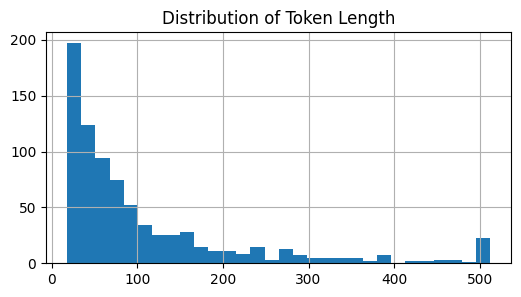

In [590]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in tokenized_datasets_train['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

In [591]:
# textカラムの削除
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['text'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['text'])

In [592]:
# token_type_idsカラムの削除
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['token_type_ids'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['token_type_ids'])

DistilBERT doesn’t have token_type_ids: https://huggingface.co/docs/transformers/model_doc/distilbert#usage-tips

In [593]:
# labelカラムをlabelsへリネーム
tokenized_datasets_train = tokenized_datasets_train.rename_column('label', 'labels')
tokenized_datasets_test = tokenized_datasets_test.rename_column('label', 'labels')

In [594]:
tokenized_datasets_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 800
})

In [595]:
tokenized_datasets_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [596]:
# tensor型に変換
tokenized_datasets_train.set_format("torch")
tokenized_datasets_test.set_format("torch")

In [597]:
tokenized_datasets_train[0]

{'labels': tensor(0),
 'input_ids': tensor([    2,   180, 10807,  1685,    47,   524,  1749,    14,   621,     5,
             9,  1685,  5231,    16,    54,     9,    20,   124,   368,    15,
           318,    39,    14,     6,  1784, 10234, 13016, 10143, 10143,  1363,
             5,  4487,     5,   788, 10611,    14, 10039,    12,    42,  3031,
             9,    10,    50,     5,     9,  2593,  2767,     9,   162,   949,
            13,  2678,    17,    12,   525,   231,     8,  3947,  5442,     5,
          1551,    14, 10039,    12,   282,  1546,  7365,    70,    11,     8,
          6202,     5,  2191,   774,     7,   136,   502,     8,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])}

In [598]:
type(tokenized_datasets_train[0]['labels'])

torch.Tensor

### Dataloder

In [599]:
tokenizer

BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [600]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", max_length=512)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=512)

Collator: https://huggingface.co/docs/transformers/ja/main_classes/data_collator

In [601]:
batch_size = 8

train_dataloader = DataLoader(tokenized_datasets_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets_test, batch_size=batch_size, collate_fn=data_collator)

In [602]:
train_dataloader

In [603]:
train_dataloader.collate_fn

DataCollatorWithPadding(tokenizer=BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)

In [604]:
len(train_dataloader), len(eval_dataloader)

(100, 25)

In [605]:
800/batch_size, 200/batch_size

(100.0, 25.0)

### Model

In [606]:
model = AutoModelForSequenceClassification.from_pretrained('line-corporation/line-distilbert-base-japanese', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at line-corporation/line-distilbert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [607]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

https://huggingface.co/docs/transformers/v4.14.1/model_doc/distilbert#transformers.DistilBertForSequenceClassification

In [608]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(32768, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [609]:
model.config

DistilBertConfig {
  "_name_or_path": "line-corporation/line-distilbert-base-japanese",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": true,
  "tie_weights_": true,
  "transformers_version": "4.40.1",
  "vocab_size": 32768
}

In [610]:
# Model check
# (batch size, token length)
sample_out = model(
    input_ids=torch.zeros((4, 15), dtype=torch.int),
    attention_mask=torch.zeros((4, 15), dtype=torch.int)
)
#sample_out

In [611]:
len(sample_out)

2

In [612]:
sample_out[0]

tensor([[0.1605, 0.2709],
        [0.1605, 0.2709],
        [0.1605, 0.2709],
        [0.1605, 0.2709]], grad_fn=<AddmmBackward0>)

In [613]:
# logitでのアウトプット
sample_out.logits

tensor([[0.1605, 0.2709],
        [0.1605, 0.2709],
        [0.1605, 0.2709],
        [0.1605, 0.2709]], grad_fn=<AddmmBackward0>)

In [614]:
# max index
torch.argmax(sample_out.logits, dim=-1)

tensor([1, 1, 1, 1])

In [615]:
sample_out.logits.shape

torch.Size([4, 2])

In [616]:
#sample_out[1]

In [617]:
#sample_out.hidden_states

In [618]:
len(sample_out.hidden_states)

7

In [619]:
for i in range(len(sample_out.hidden_states)):
    print(sample_out.hidden_states[i].shape, sample_out[1][i].mean(), sample_out[1][i].std())

torch.Size([4, 15, 768]) tensor(-0.0163, grad_fn=<MeanBackward0>) tensor(0.7592, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0044, grad_fn=<MeanBackward0>) tensor(0.5720, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0038, grad_fn=<MeanBackward0>) tensor(0.7768, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0017, grad_fn=<MeanBackward0>) tensor(0.7886, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(0.0037, grad_fn=<MeanBackward0>) tensor(0.8767, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(0.0016, grad_fn=<MeanBackward0>) tensor(0.8713, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0112, grad_fn=<MeanBackward0>) tensor(0.8957, grad_fn=<StdBackward0>)


### Optimizer, Scheduler

In [620]:
model.parameters()

<generator object Module.parameters at 0x7f8a8a4f86d0>

In [621]:
optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.01
)

In [622]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
print(len(train_dataloader), num_training_steps)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
lr_scheduler

100 200


### Training

In [623]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [624]:
train_dataloader

In [625]:
progress_bar = tqdm(range(num_training_steps))

model.to(device)
model.train()

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    for batch in train_dataloader:
        #print(batch.keys())
        #print("input_ids shape: ", batch['input_ids'].shape)
        #print("attention_mask shape: ", batch['attention_mask'].shape)
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1/2
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 233])
attention_mask shape:  torch.Size([8, 233])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 143])
attention_mask shape:  torch.Size([8, 143])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 426])
attention_mask shape:  torch.Size([8, 426])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 512])
attention_mask shape:  torch.Size([8, 512])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 134])
attention_mask shape:  torch.Size([8, 134])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 134])
attention_mask shape:  torch.Size([8, 134])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 191])
attention_mask shape:  torch.Size([8, 191])
dict_keys(['labels', 'input_ids', 'at

dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 388])
attention_mask shape:  torch.Size([8, 388])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 512])
attention_mask shape:  torch.Size([8, 512])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 379])
attention_mask shape:  torch.Size([8, 379])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 284])
attention_mask shape:  torch.Size([8, 284])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 512])
attention_mask shape:  torch.Size([8, 512])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 88])
attention_mask shape:  torch.Size([8, 88])
dict_keys(['labels', 'input_ids', 'attention_mask'])
input_ids shape:  torch.Size([8, 96])
attention_mask shape:  torch.Size([8, 96])
dict_keys(['labels', 'input_ids', 'attention_mask'])

KeyboardInterrupt: 